In [1]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:54300' processes=4 threads=12, memory=32.00 GiB>

<Client: 'tcp://127.0.0.1:54300' processes=4 threads=12, memory=32.00 GiB>

[SUCCESS] 09:33AM: Saved stream to /Users/moo270/code/visualisation_toolbox/goes_custom.gif.
[WARNING] 09:33AM: The output displayed below could be an older, cached version; click the path above to view the latest.


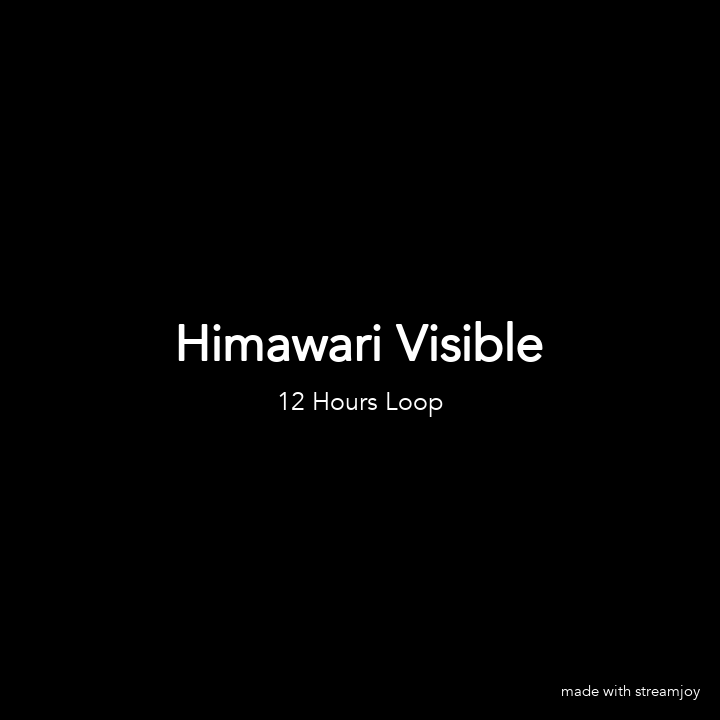

[SUCCESS] 09:33AM: Optimized stream with pygifsicle at /Users/moo270/code/visualisation_toolbox/goes_custom.gif.


In [6]:
from streamjoy import stream

if __name__ == "__main__":
    URL_FMT = "https://www.goes.noaa.gov/dimg/jma/fd/vis/{i}.gif"
    resources = [URL_FMT.format(i=i) for i in range(1, 11)]
    himawari_stream = stream(
        resources,
        uri="goes_custom.gif",
        intro_title="Himawari Visible",
        intro_subtitle="10 Hours Loop",
        intro_pause=1,
        ending_pause=1,
        optimize=True,
    )

In [ ]:
from streamjoy import stream
import xarray as xr

ds = xr.tutorial.open_dataset("air_temperature").isel(time=slice(0, 100))
stream(ds, uri="air.gif", cmap="RdBu_r")

[WARNING] 09:06AM: No 'var' specified; using the default 'anom' from the dataset. Suppress this by passing 'var'.
[WARNING] 09:06AM: No 'dim' specified; using the default 'time' from the dataset. Suppress this by passing 'dim'.


<Client: 'tcp://127.0.0.1:54300' processes=4 threads=12, memory=32.00 GiB>

/Users/moo270/mambaforge/envs/pangeo_streamjoy/lib/python3.12/site-packages/matplotlib/colors.py:743: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
[SUCCESS] 09:06AM: Saved stream to /Users/moo270/code/visualisation_toolbox/oisst.gif.
[WARNING] 09:06AM: The output displayed below could be an older, cached version; click the path above to view the latest.


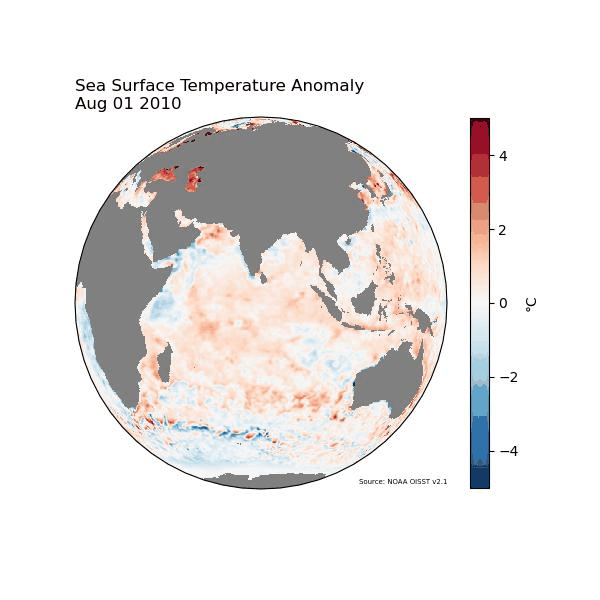

In [3]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from streamjoy import stream, wrap_matplotlib

@wrap_matplotlib()
def plot(da, central_longitude, **plot_kwargs):
    time = da["time"].dt.strftime("%b %d %Y").values.item()
    projection = ccrs.Orthographic(central_longitude=central_longitude)
    subplot_kw = dict(projection=projection, facecolor="gray")
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=subplot_kw)
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax.set_title(f"Sea Surface Temperature Anomaly\n{time}", loc="left", transform=ax.transAxes)
    ax.set_title("Source: NOAA OISST v2.1", loc="right", size=5, y=-0.01)
    ax.set_title("", loc="center")  # suppress default title
    plt.colorbar(im, ax=ax, label="°C", shrink=0.8)
    return fig

if __name__ == "__main__":
    url = (
      "https://www.ncei.noaa.gov/data/sea-surface-temperature-"
      "optimum-interpolation/v2.1/access/avhrr/201008/"
    )
    pattern = "oisst-avhrr-v02r01.*.nc"
    max_files = 30
    stream(
        url,
        uri="oisst.gif",
        pattern=pattern,  # GifStream.from_url kwargs
        max_files=max_files,
        renderer=plot,  # renderer related kwargs
        renderer_iterables=[np.linspace(80, 170, max_files)],  # iterables; central longitude per frame (30 frames)
        renderer_kwargs=dict(cmap="RdBu_r", vmin=-5, vmax=5),  # renderer kwargs
        # cmap="RdBu_r", # renderer_kwargs can also be propagated for convenience
        # vmin=-5,
        # vmax=5,
    )

In [ ]:
import cartopy.crs as ccrs
from streamjoy import stream

YEAR = 2023
URL_FMT = "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/{year}{month:02}/"

if __name__ == "__main__":
    streams = []
    for month in range(1, 13):
        url = URL_FMT.format(year=YEAR, month=month)
        streams.append(
            stream(
                url,
                pattern="oisst-avhrr-v02r01*.nc",
                var="anom",
                dim="time",
                max_files=29,
                max_frames=-1,
                renderer_kwargs=dict(
                    cmap="RdBu_r",
                    vmin=-5,
                    vmax=5,
                    subplot_kws=dict(
                        projection=ccrs.Orthographic(central_longitude=-150),
                        facecolor="gray",
                    ),
                    transform=ccrs.PlateCarree(),
                ),
            )
        )

    joined_stream = sum(streams)
    joined_stream.write("oisst_globe.gif")